# House Prices - Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

In [1569]:
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
%matplotlib inline

In [1570]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1571]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

As seen above there are 78 categories (excluding ID and SalePrice) that can affect the sales price of a home. There are 2 types of data present; numeric and categorical. 36 of the 78 categories are numeric. Through the use of a heat map we can quickly see which of the 36 numeric categories correlate strongly with SalePrice

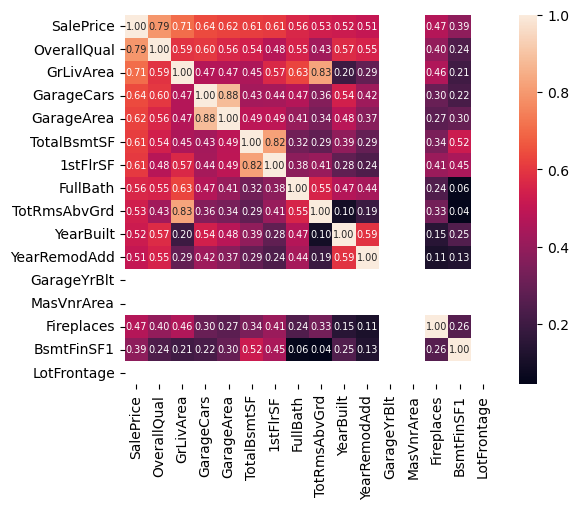

In [1572]:
numeric_df = train_data.select_dtypes(include=["number"])

correl = numeric_df.corr()

k = 16 #number of variables for heatmap
cols = correl.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(numeric_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


From the above map on the top row and first column we can detrmine the useful catgories. In accordance with this chart the numeric categories taken in consideration will be: 

OverallQual,GrLivArea, GarageCars, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt, and YearRemodAdd.

Additionally, GarageCars and GarageArea messure the smae thing so GarageArea can be pruned as it does the same thing as GarageCars but worse.



Now that we have outlined the categories we will use we can prune away any possible outliers.

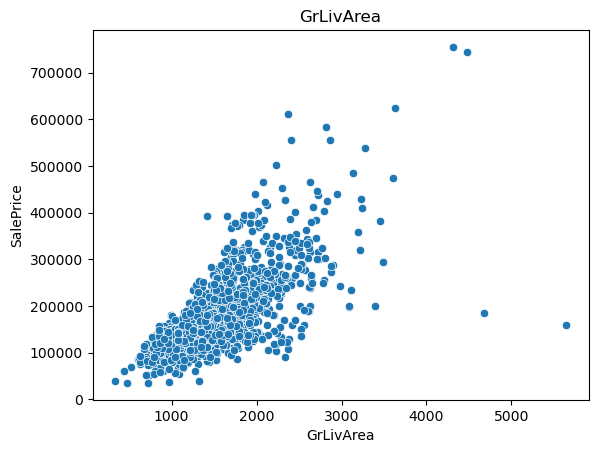

In [1573]:
sns.scatterplot(data=train_data, x='GrLivArea', y='SalePrice')
plt.title('GrLivArea')
plt.show()

train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)

In [1574]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   int64  
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1199 non-null   float64
 4   LotArea        1458 non-null   int64  
 5   Street         1458 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1458 non-null   object 
 8   LandContour    1458 non-null   object 
 9   Utilities      1458 non-null   object 
 10  LotConfig      1458 non-null   object 
 11  LandSlope      1458 non-null   object 
 12  Neighborhood   1458 non-null   object 
 13  Condition1     1458 non-null   object 
 14  Condition2     1458 non-null   object 
 15  BldgType       1458 non-null   object 
 16  HouseStyle     1458 non-null   object 
 17  OverallQual    1458 non-null   int64  
 18  OverallCond  

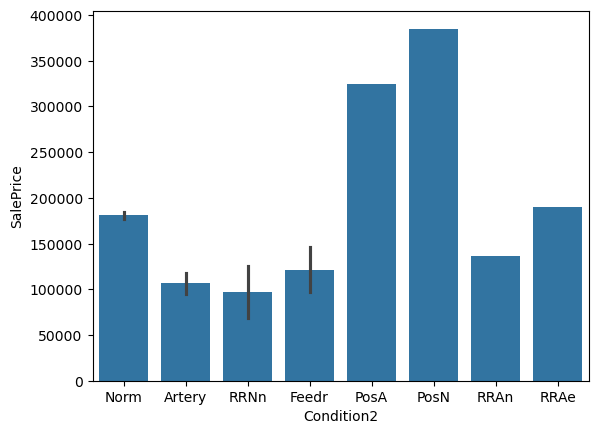

In [ ]:
sns.barplot(data = train_data, x = 'Condition2',y = 'SalePrice')
plt.show()

#Qualitative to Convert: 
# Street: Pave = 1 Grvl = 0
# LandContour: Bnk = 0, Lvl = 1, Low = 2, HLS = 3
# Utilities: AllPub = 1, NoSeWa = 0
# Condition2 RRNn = 0 , Artery = 1, Feedr = 2, RRAn = 3, Norm = 4, RRAe = 5, PosA = 6, PosN = 7


In [ ]:
combine = [train_data, test_data]

for dataset in combine:
    dataset['Street'] = dataset['Street'].replace('Pave', 1)
    dataset['Street'] = dataset['Street'].replace('Grvl', 0)


In [1576]:
Using_Lasso = True

if Using_Lasso == True:
    train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

    train_data["GrLivArea"] = np.log1p(train_data["GrLivArea"])
    test_data["GrLivArea"] = np.log1p(test_data["GrLivArea"])

    train_data["TotalBsmtSF"] = np.log1p(train_data["TotalBsmtSF"])
    test_data["TotalBsmtSF"] = np.log1p(test_data["TotalBsmtSF"])

    train_data["1stFlrSF"] = np.log1p(train_data["1stFlrSF"])
    test_data["1stFlrSF"] = np.log1p(test_data["1stFlrSF"])

    train_data['YearBuilt'] = train_data['YearBuilt'] - 1872
    test_data['YearBuilt'] = test_data['YearBuilt'] - 1879

    train_data["YearBuilt"] = np.log1p(train_data["YearBuilt"])
    test_data["YearBuilt"] = np.log1p(test_data["YearBuilt"])

    train_data['YearRemodAdd'] = train_data['YearRemodAdd'] - 1950
    test_data['YearRemodAdd'] = test_data['YearRemodAdd'] - 1950

    train_data['GarageYrBlt'] = train_data['GarageYrBlt'] - 1900
    test_data['GarageYrBlt'] = test_data['GarageYrBlt'] - 1895

    train_data["GarageYrBlt"] = np.log1p(train_data["GarageYrBlt"])
    test_data["GarageYrBlt"] = np.log1p(test_data["GarageYrBlt"])


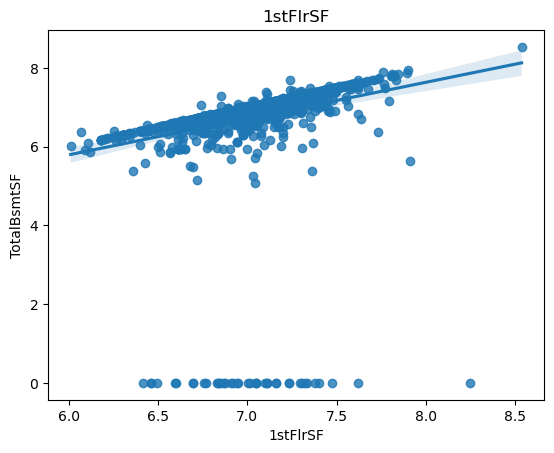

y = 0.92x + 0.26


In [1577]:
sns.regplot(data=test_data, x='1stFlrSF', y='TotalBsmtSF')
plt.title('1stFlrSF')
plt.show()

new_frame = pd.DataFrame({'1stFlrSF': test_data['1stFlrSF'],'TotalBsmtSF': test_data['TotalBsmtSF']})

new_frame = new_frame.dropna()

x = new_frame['1stFlrSF']
y = new_frame['TotalBsmtSF']

m, b = np.polyfit(x, y, 1)

# Print the equation of the line
print(f"y = {m:.2f}x + {b:.2f}")

test_data['TotalBsmtSF'] = test_data.apply(lambda row: row['1stFlrSF'] * m + b if pd.isna(row['TotalBsmtSF']) else row['TotalBsmtSF'] ,axis= 1)

In [1578]:
mean_cars = test_data['GarageCars'].mean()
print(mean_cars)

test_data['GarageCars'] = test_data['GarageCars'].fillna(1.7661179698216736)

1.7661179698216736


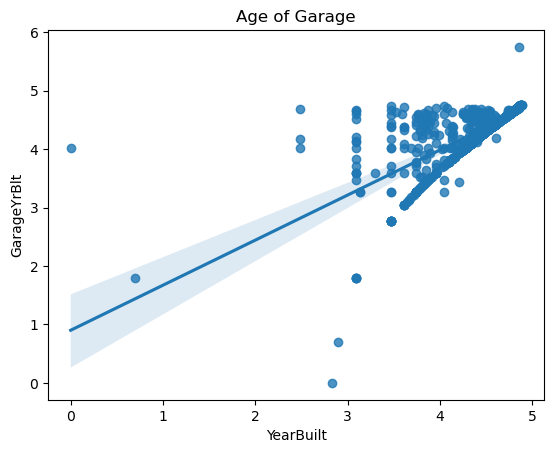

y = 0.77x + 0.90


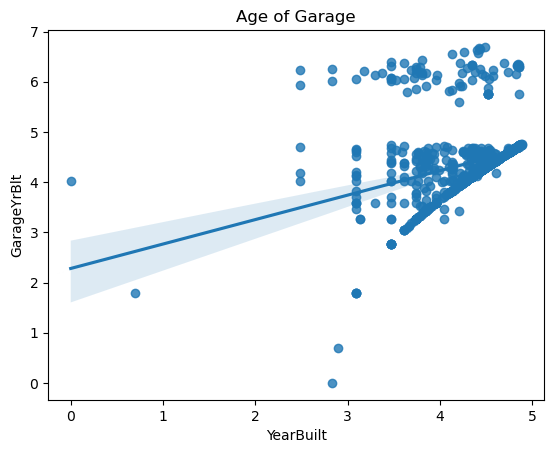

y = 0.79x + 0.72


In [1579]:
sns.regplot(data=test_data, x='YearBuilt', y='GarageYrBlt')
plt.title('Age of Garage')
plt.show()

new_frame = pd.DataFrame({'YearBuilt': test_data['YearBuilt'],'GarageYrBlt': test_data['GarageYrBlt']})
new_frame = new_frame.dropna()
x = new_frame['YearBuilt']
y = new_frame['GarageYrBlt']
m, b = np.polyfit(x, y, 1)
# Print the equation of the line
print(f"y = {m:.2f}x + {b:.2f}")
test_data['GarageYrBlt'] = test_data.apply(lambda row: row['1stFlrSF'] * m + b if pd.isna(row['GarageYrBlt']) else row['GarageYrBlt'] ,axis= 1)

sns.regplot(data=test_data, x='YearBuilt', y='GarageYrBlt')
plt.title('Age of Garage')
plt.show()

new_frame = pd.DataFrame({'YearBuilt': train_data['YearBuilt'],'GarageYrBlt': train_data['GarageYrBlt']})
new_frame = new_frame.dropna()
x = new_frame['YearBuilt']
y = new_frame['GarageYrBlt']
m, b = np.polyfit(x, y, 1)
# Print the equation of the line
print(f"y = {m:.2f}x + {b:.2f}")
train_data['GarageYrBlt'] = train_data.apply(lambda row: row['1stFlrSF'] * m + b if pd.isna(row['GarageYrBlt']) else row['GarageYrBlt'] ,axis= 1)

In [1580]:
y = train_data["SalePrice"]

if Using_Lasso:
    features = ["GarageYrBlt","Fireplaces","OverallQual","GrLivArea","TotalBsmtSF","GarageCars","1stFlrSF","FullBath","TotRmsAbvGrd", "YearBuilt" ,"YearRemodAdd"]

    model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train_data[features], train_data['SalePrice'])
    lasso_preds = np.expm1(model_lasso.predict(test_data[features]))

    solution = pd.DataFrame({"Id":test_data.Id, "SalePrice":lasso_preds})
    solution.to_csv("Predictions.csv", index = False)
    


Lasso Score : .15819